(Semi)Automated Exploratory Data Analysis for any (reasonable) Dataframe
==============================

While there is no substitute for a human being looking at data in multiple ways, both using visualizations and manual wrangling, it is possible to automate the first few steps of exploratory data analysis. 

This notebook is an attempt at doing precisely that - making it easier to start asking the right questions. Additionally, since I am myself a beginner, it might also serve to instruct others like me. 

I hope to keep updating this notebook over time, and hopefully add new tricks. 


Step 0. Check dependencies
------------------------------
When pandas is installed via pip, certain optional dependencies are not installed by default. These can be found in the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/install.html#install-recommended-dependencies). For this notebook, we installed `scipy`, `xarray`, `matplotlib`, `numexpr` and `bottleneck` via pip and `xclip` via apt-get. 

In [1]:
import pandas as pd
# check that bottleneck andnumexpr are enabled by default
# pd.get_option('compute.use_bottleneck')
# pd.get_option('compute.use_numexpr')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import wget
from IPython.display import display,HTML

Step 1. Import Data
----------------------

As an example I shall use a publicly available csv file, wrapped in a custom function that caches it locally. If this code is run for the first time in a fresh directory, the data shall be downloaded and stored for all future iterations of the code.

Remember to use `display()` from `Ipython.display` instead of print to obtain the nice htmlview for dataframes. 

In [2]:
def get_csv_data(filename=None, 
                 URI=None,**kwargs):
    '''
    Download and cache csv data locally
    We can pass any read_csv keyword args via this function.
    '''
    try:
        df = pd.read_csv(filename,**kwargs)
    except (OSError, IOError) as e:
        wget.download(URI, filename)
        df = pd.read_csv(filename,**kwargs)
    return df

In [3]:
filename = "train.csv"
file_href = r"https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv"
#refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html for more on the arguments
csv_to_df_args = {}

df = get_csv_data(filename=filename,
                        URI=file_href)
display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


Step 2. Check and group by datatypes
-----------------------------
1. Set index: in this case, we use `PassengerId` as the natural choice. Note how the output if `df.info()` changes. If there is a timestamp field, set that as the index.
2. Change dates to `datetime` objects using `pd.to_datetime`. 
3. Group dataframes by datatypes - check if there are any surprises, like a datetime field interpreted as a string. The `object` datatype in the output of `df.info()` behaves like a string for most operations.


In [5]:
df = df.set_index("PassengerId")
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
dtype_groups = df.columns.to_series().groupby(df.dtypes).groups
dtype_groups

{dtype('int64'): Index(['Survived', 'Pclass', 'SibSp', 'Parch'], dtype='object'),
 dtype('float64'): Index(['Age', 'Fare'], dtype='object'),
 dtype('O'): Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')}

the above dtype objects are from `np.dtype`.

In [8]:
for dtype,dtype_df in dtype_groups.items():
    display(HTML("<h3>{}</h3>".format(dtype)))
    display(df[dtype_df])


,Survived,Pclass,SibSp,Parch
PassengerId,,,,
1,0,3,1,0
2,1,1,1,0
3,1,3,0,0
4,1,1,1,0
5,0,3,0,0
6,0,3,0,0
7,0,1,0,0
8,0,3,3,1
9,1,3,0,2


,Age,Fare
PassengerId,,
1,22.0,7.2500
2,38.0,71.2833
3,26.0,7.9250
4,35.0,53.1000
5,35.0,8.0500
6,NaN,8.4583
7,54.0,51.8625
8,2.0,21.0750
9,27.0,11.1333


,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,"Allen, Mr. William Henry",male,373450,NaN,S
6,"Moran, Mr. James",male,330877,NaN,Q
7,"McCarthy, Mr. Timothy J",male,17463,E46,S
8,"Palsson, Master. Gosta Leonard",male,349909,NaN,S
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,347742,NaN,S


Now that we have segregated columns by datatypes, we can apply different univariate analyses to these columns. 

Note that the choice of index is very important to the histograms and scatter plots that we shall obtain. 

Step 3.  Missing values
--------------------------

While missing values can be ignored or imputed in many ways, a quick look at where they occur can reveal patterns. This is accomplished using `the missingno` module.  

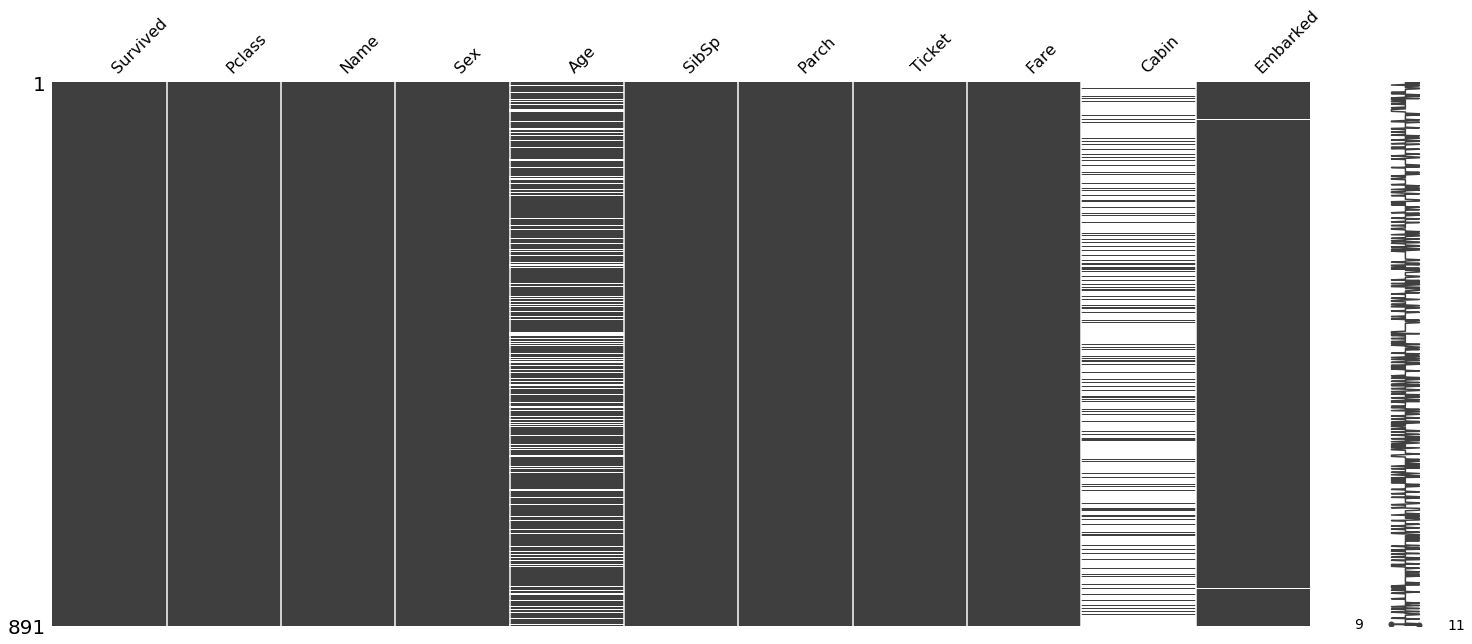

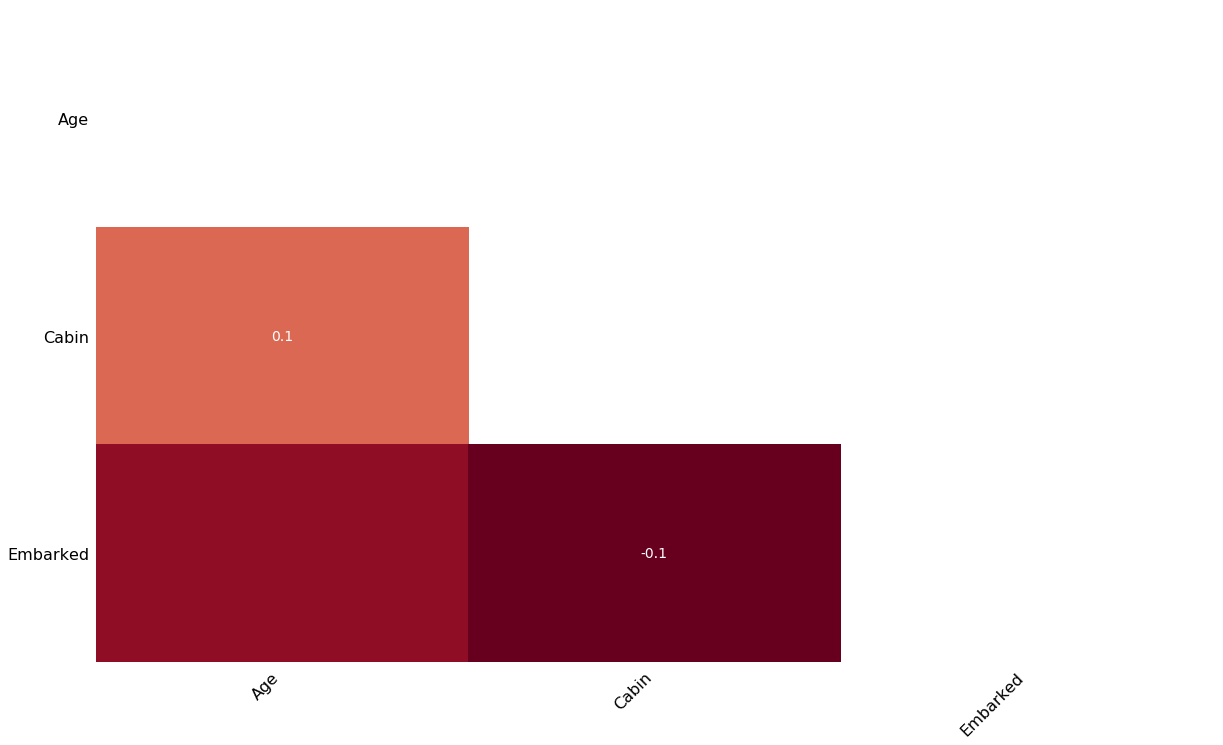

In [45]:
msno.matrix(df)
msno.heatmap(df)

This reveals to us that only the age column has missing values. We can quickly compare this to the original titanic dataset, which has not been cleaned up.

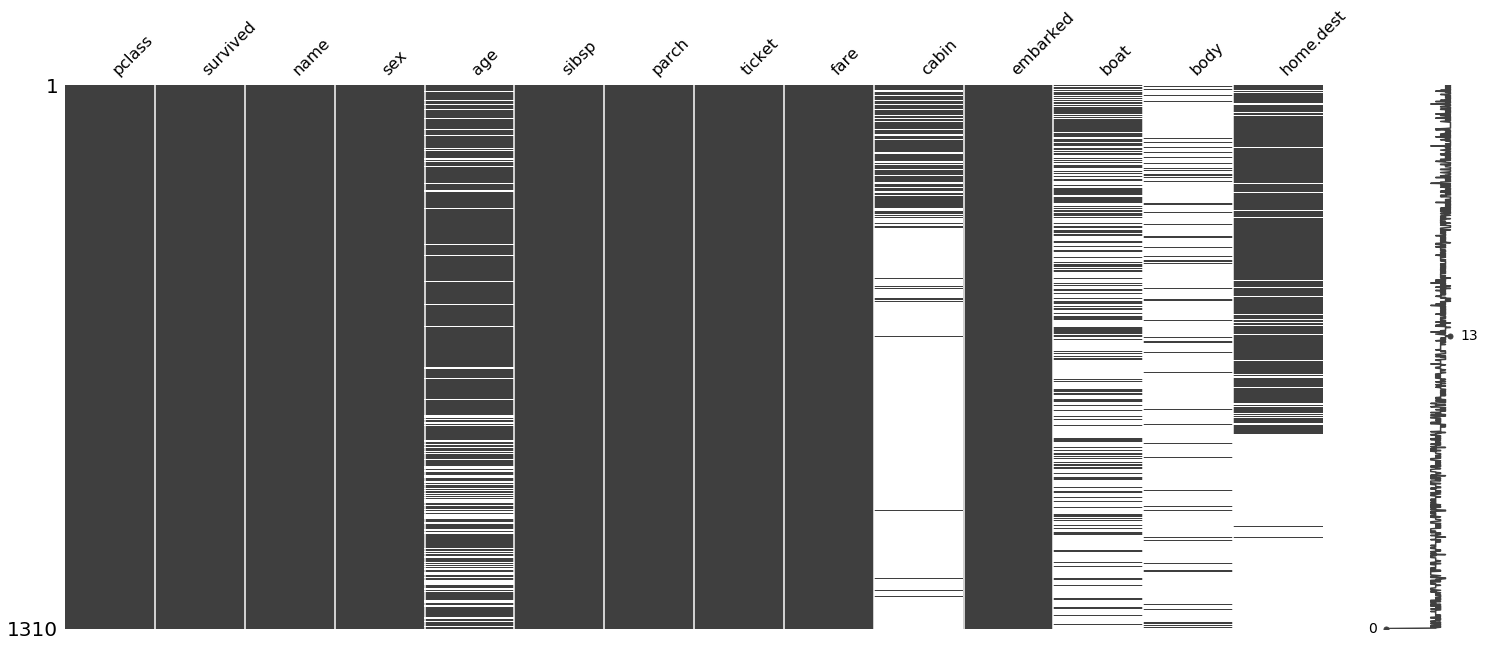

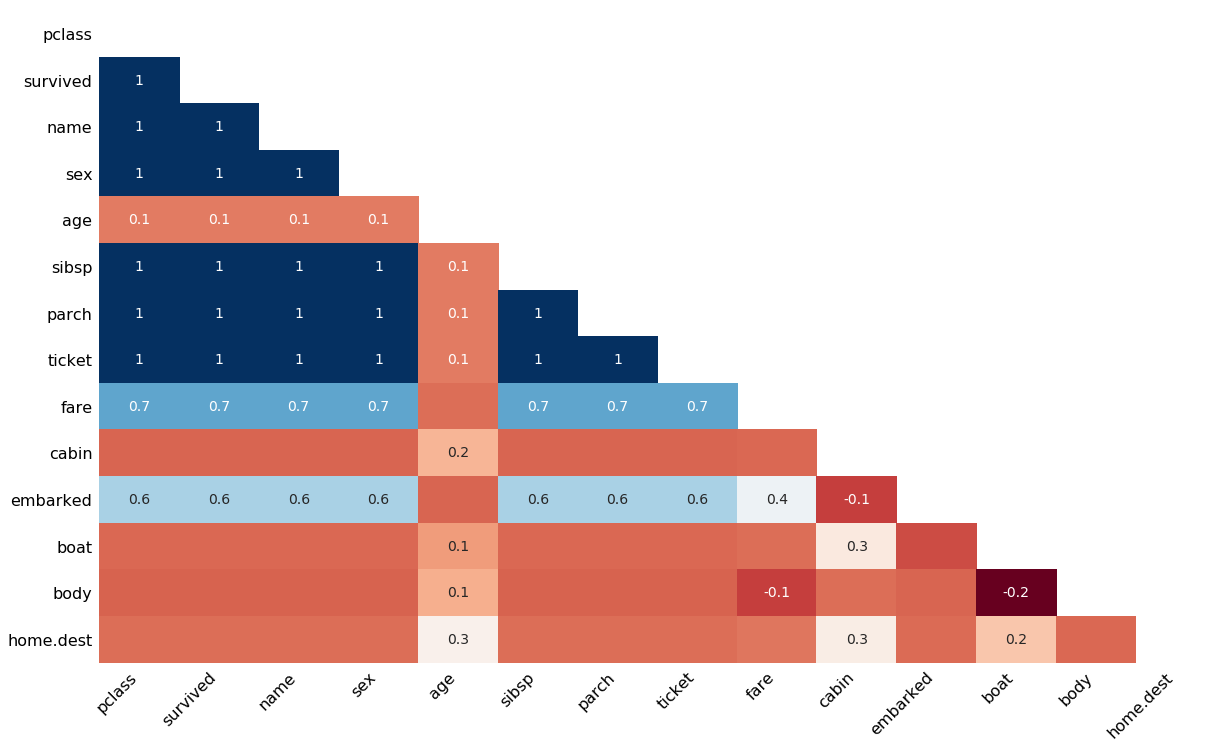

In [10]:
titanic_original = pd.read_csv("https://raw.githubusercontent.com/Geoyi/Cleaning-Titanic-Data/master/titanic_original.csv")
msno.matrix(titanic_original)
msno.heatmap(titanic_original)

>Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).  
Variables that are always full or always empty have no meaningful correlation, and so are silently removed from the visualization—in this case for instance the datetime and injury number columns, which are completely filled, are not included.  
Entries marked <1 or >-1 are have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so. This points to a small number of records in the dataset which are erroneous. For example, in this dataset the correlation between VEHICLE CODE TYPE 3 and CONTRIBUTING FACTOR VEHICLE 3 is <1, indicating that, contrary to our expectation, there are a few records which have one or the other, but not both. These cases will require special attention.  
The heatmap works great for picking out data completeness relationships between variable pairs, but its explanatory power is limited when it comes to larger relationships and it has no particular support for extremely large datasets.  

-from the [missingno github README](https://github.com/ResidentMario/missingno). 

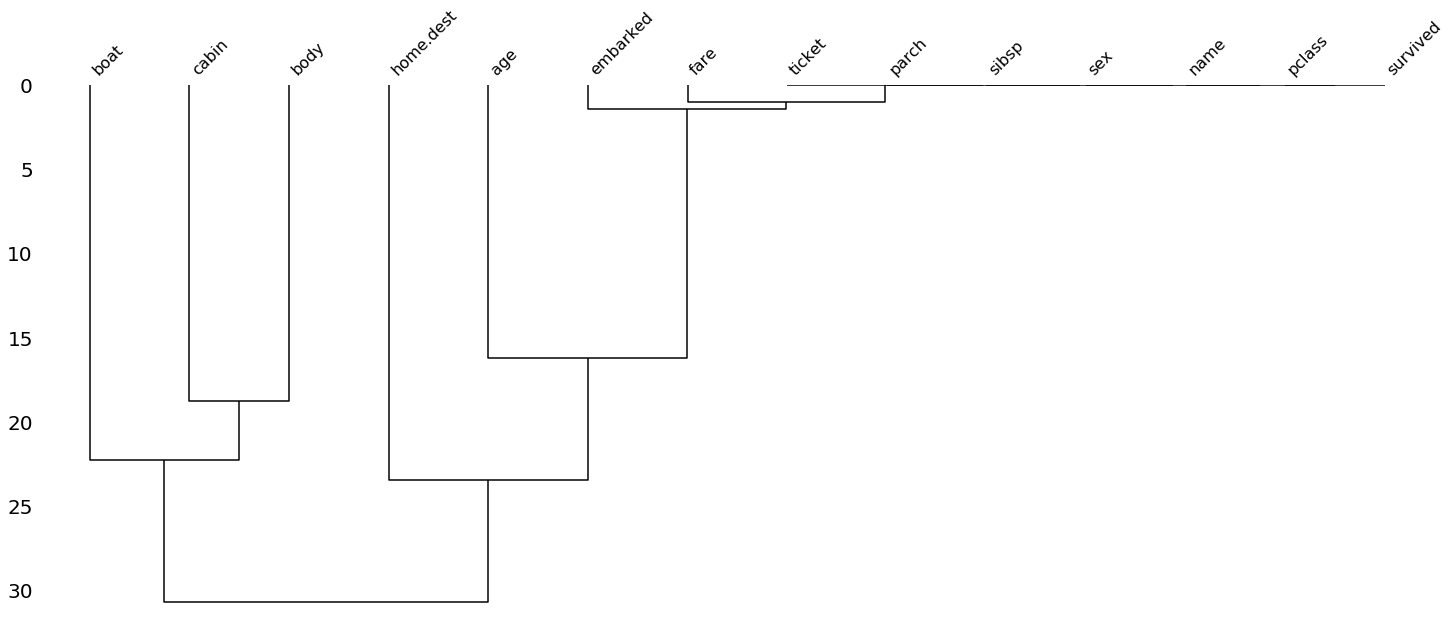

In [11]:
msno.dendrogram(titanic_original)


This plot is called a dendogram and can be interpreted as follows - 

> The dendrogram uses a hierarchical clustering algorithm (courtesy of scipy) to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.  
To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record.

- from the [missingno github README](https://github.com/ResidentMario/missingno). 

Histograms for continuous numerical data
----------------------------------

In [16]:
cols_num = dtype_groups[np.dtype('float64')]
df[cols_num]

,Age,Fare
PassengerId,,
1,22.0,7.2500
2,38.0,71.2833
3,26.0,7.9250
4,35.0,53.1000
5,35.0,8.0500
6,NaN,8.4583
7,54.0,51.8625
8,2.0,21.0750
9,27.0,11.1333


In [12]:
dtype_groups

{dtype('int64'): Index(['Survived', 'Pclass', 'SibSp', 'Parch'], dtype='object'),
 dtype('float64'): Index(['Age', 'Fare'], dtype='object'),
 dtype('O'): Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')}

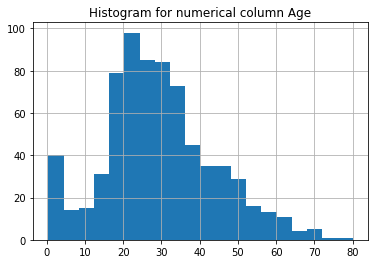

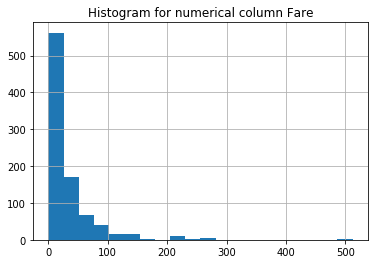

In [36]:
for col in cols_num:
    plt.figure()
    df[col].hist(bins=20)
    plt.title("Histogram for numerical column {}".format(col))
    

Lets impute the missing values in `Age` with the mean 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x147dec3ceda0>]],
      dtype=object)

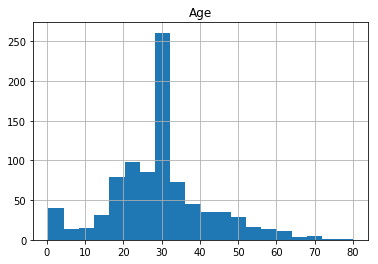

In [35]:
imputed_age = df[['Age']]
imputed_age.fillna(imputed_age.mean()).hist(bins=20)

Histogram of categorical plots
----------------------------------

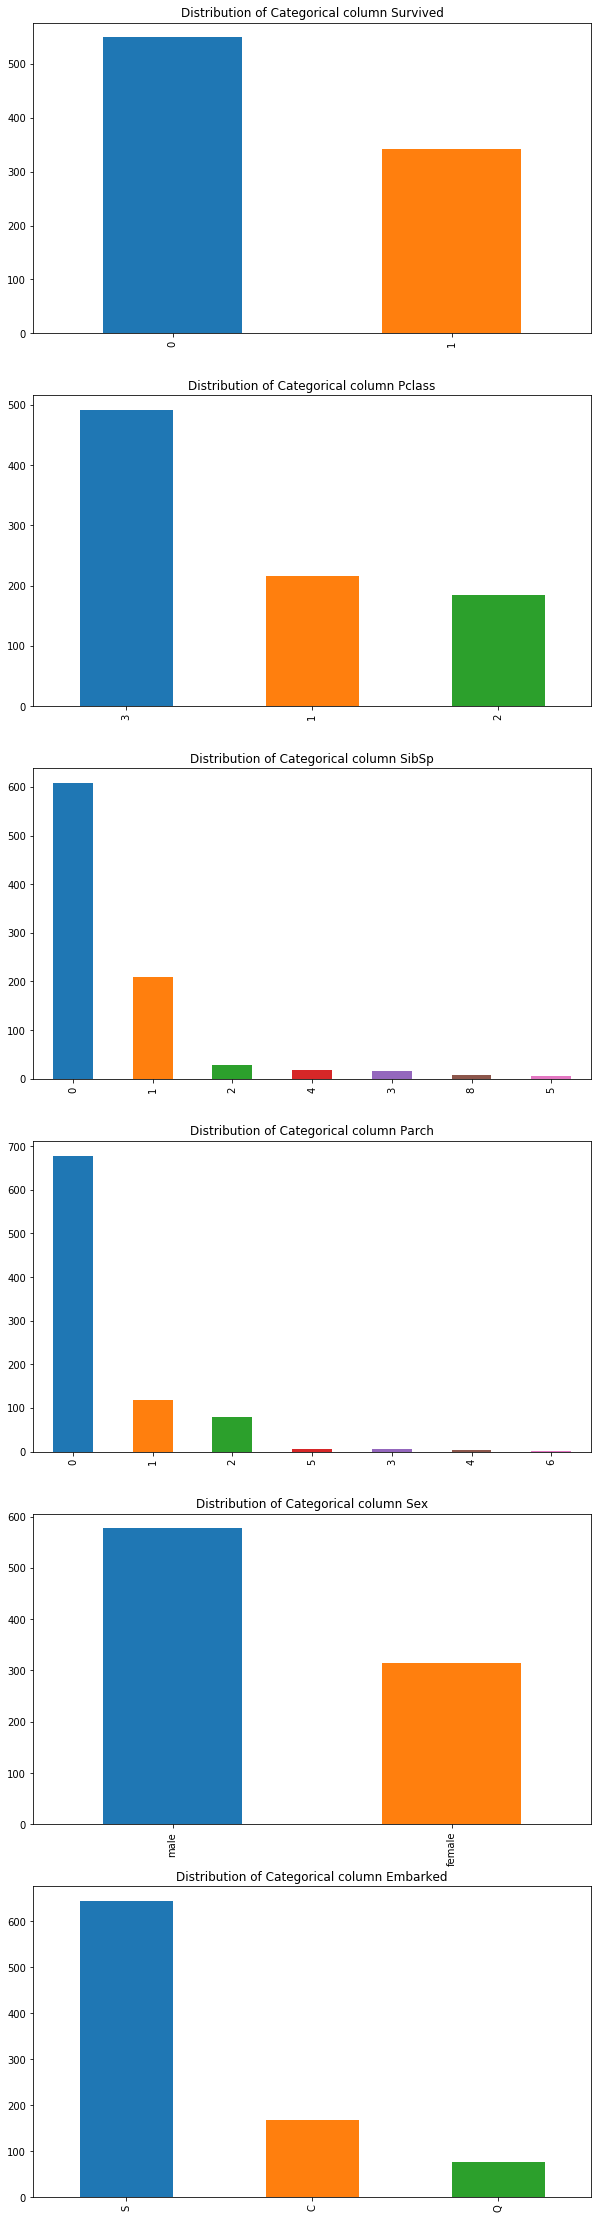

In [68]:
cols_int = dtype_groups[np.dtype('int64')]
cols_str = dtype_groups[np.dtype('O')]


cols_categorical = list(cols_int)+['Sex','Embarked']
fig, axs = plt.subplots(ncols=1, 
                        nrows=len(cols_categorical),
                        figsize=(10, 40))
for i,col in enumerate(cols_categorical):
    df[col].value_counts().plot(kind='bar',ax=axs[i])
    axs[i].set_title('Distribution of Categorical column {}'.format(col))
